## I am using Google's Gemini as my LLM model as the OpenAI's GPT models are paid.

 **For them to access I had to add payment detail (which I avoid in most cases due to data leakage and fraud) and add some credite in OpenAI API website.**
 
**Everything is exactly same as expected in the project.**



In [4]:
# These should already be installed on your workspace
!pip install --disable-pip-version-check --quiet -U langchain==0.2.16
!pip install --disable-pip-version-check --quiet -U langchain_openai==0.1.23
!pip install --disable-pip-version-check --quiet -U langgraph==0.2.19
!pip install --disable-pip-version-check --quiet -U langchainhub==0.1.21
!pip install --disable-pip-version-check --quiet -U tavily-python==0.4.0
!pip install --disable-pip-version-check --quiet -U langchain-community==0.2.16
!pip install --disable-pip-version-check --quiet -U python-dotenv==1.0.1
!pip install --disable-pip-version-check --quiet -U google-generativeai
!pip install --disable-pip-version-check --quiet -U langchain-google-genai==1.0.5

I0000 00:00:1730543578.595532      13 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1730543581.866070      13 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
Exception ignored in: <function _releaseLock at 0x7d65608da950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
I0000 00:00:1730543584.057752      13 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1730543586.224521      13 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1730543588.296718      13 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1730543590.420803      13 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 1.0.5 requires google-generativeai<0.6.0,>=0.5.2, but you have google-generativeai 0.8.3 which is incompatible.


I0000 00:00:1730543599.056148      13 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [2]:
# Helper functions
def display_text_to_user(text):
    print(text)
    time.sleep(1)

def ask_user_for_input(input_description):
    response = input(input_description)
    return response

/opt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


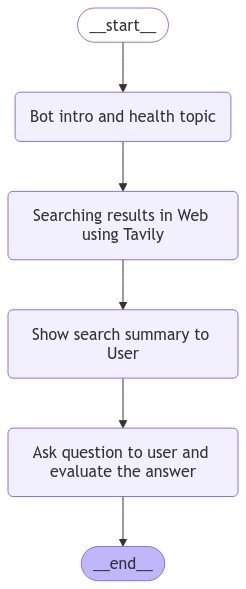

Hello! I'm HealthBot. What health topic or medical condition would you like to learn about today?
Please enter your topic: high bp


/tmp/ipykernel_13/2697781154.py:56: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  chain = LLMChain(llm=model, prompt=prompt)
/tmp/ipykernel_13/2697781154.py:57: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  summary = chain.run(search_results=state["search_results"])


Here's a summary of what I found about high bp:
**What is High Blood Pressure (Hypertension)?**

High blood pressure, also known as hypertension, is when the force of your blood against the walls of your blood vessels is too high. This constant pressure can damage your arteries and lead to health problems like heart disease and stroke.

**Causes:**

Most of the time, the cause of high blood pressure is unknown, but some things can make you more likely to have it, such as:

* Being overweight or obese
* Not eating healthy
* Not getting enough exercise
* Smoking
* Drinking too much alcohol
* Having a family history of high blood pressure

**Symptoms:**

Most people with high blood pressure don't have any symptoms. But some may experience:

* Headaches
* Nosebleeds
* Dizziness
* Chest pain
* Shortness of breath

**Diagnosis and Treatment:**

Your doctor will diagnose high blood pressure by measuring it with a blood pressure cuff. If your blood pressure is high, they may recommend lifestyl

In [3]:
from dotenv import load_dotenv
import os
import time
from langgraph.graph import MessagesState, START, StateGraph, END
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from IPython.display import Image, display
from tavily import TavilyClient
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from typing import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI


class State(TypedDict):
    health_topic: str
    search_results: str
    summary: str
    messages: list
    restart: bool

# Loading config file
load_dotenv('config.env')
assert os.getenv('OPENAI_API_KEY') is not None
assert os.getenv('TAVILY_API_KEY') is not None
assert os.getenv('GEMINI_API_KEY') is not None

# Initialize the Google Generative AI model
model = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=os.getenv("GEMINI_API_KEY"))
# model = ChatOpenAI(temperature=0, streaming=True, api_key=os.getenv('OPENAI_API_KEY'))



workflow = StateGraph(State)

def BotIntroAndTopic(state: State):
    display_text_to_user("Hello! I'm HealthBot. What health topic or medical condition would you like to learn about today?")
    health_topic = ask_user_for_input("Please enter your topic: ")
    state.update({"health_topic": health_topic})
    return state

def SearchingResults(state: State):
    tavily = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    search_results = tavily.search(state["health_topic"])
    state.update({"search_results": search_results})
    return state

def ShowSearchSummary(state: State):
    prompt_template = """
    Please summarize the following medical information into a patient-friendly explanation:

    {search_results}
    """
    prompt = ChatPromptTemplate.from_template(prompt_template)
    chain = LLMChain(llm=model, prompt=prompt)
    summary = chain.run(search_results=state["search_results"])
    state.update({"summary": summary})
    display_text_to_user("Here's a summary of what I found about " + state["health_topic"] + ":\n" + state["summary"])
    return state

def AskQuestionAndEvaluate(state: State):
    display_text_to_user("When you're ready, please type 'ready' to proceed to a comprehension check.")
    user_input = ask_user_for_input("Please enter your input: ")
    if user_input.lower() == 'ready':
        prompt_template = """
        Generate a single question based on this text, suitable for a comprehension check:

        {summary}
        """
        prompt = ChatPromptTemplate.from_template(prompt_template)
        chain = LLMChain(llm=model, prompt=prompt)
        question = chain.run(summary=state["summary"])
        display_text_to_user(question)

        # Get user's answer
        user_answer = ask_user_for_input("Your answer: ").upper()

        # Grade the answer using Google API
        grading_prompt_template = """
        Grade the following answer to the question. Use the summary The correct answer is automatically determined by the question itself.
        Question: {question}
        User Answer: {user_answer}

        Return Grade on the scale of 1-5 along with some explaination of the grading system.
        """
        grading_prompt = ChatPromptTemplate.from_template(grading_prompt_template)
        grading_chain = LLMChain(llm=model, prompt=grading_prompt)
        grade = grading_chain.run(question=question, user_answer=user_answer)

        display_text_to_user(f"Your answer is: {grade}")

        # Ask user if they want to know about other health topic
        display_text_to_user("Would you like to learn about another topic? Type 'yes' to continue or 'no' to exit.")
        continue_input = ask_user_for_input("Your choice (yes/no): ").lower()
        if continue_input == 'yes':
            state.update({"restart": True})
        else:
            state.update({"restart": False})
            display_text_to_user("Thank you for using HealthBot. Goodbye!")
        return state
    else:
        return state

workflow.add_node("Bot intro and health topic", BotIntroAndTopic)
workflow.add_node("Searching results in Web using Tavily", SearchingResults)
workflow.add_node("Show search summary to User", ShowSearchSummary)
workflow.add_node("Ask question to user and evaluate the answer", AskQuestionAndEvaluate)

workflow.add_edge(START, "Bot intro and health topic")
workflow.add_edge("Bot intro and health topic", "Searching results in Web using Tavily")
workflow.add_edge("Searching results in Web using Tavily", "Show search summary to User")
workflow.add_edge("Show search summary to User", "Ask question to user and evaluate the answer")
workflow.add_edge("Ask question to user and evaluate the answer", END)

initial_state : State = {"messages": [], "restart" : True}
state = initial_state
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
display(Image(app.get_graph().draw_mermaid_png()))

while (state["restart"]):
  state = initial_state
  config = RunnableConfig(recursion_limit=2000, configurable={"thread_id": "2"})
  state = app.invoke(initial_state,config)

